# AuNRs DA Figure S4

In [87]:
import sys
# add path for my packages
sys.path.append('C:\\Users\\katsuya2\\OneDrive - University of Illinois - Urbana\\Documents\\Python Scripts\\my_packages')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from matplotlib import cm
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

%precision 3
%matplotlib inline

# use my matplotlib style
style_p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/my_packages")
plt.style.use(Path(style_p, 'my_rc_setting.mplstyle'))

In [88]:
def calc_dif(idx, ito_data, glass_data):
    Eres_glass = glass_data['eres'][idx]
    AR_glass = glass_data['ratio'][idx]

    upper_min = ito_data[ito_data['ratio'] > AR_glass]['ratio'].min()
    lower_max = ito_data[ito_data['ratio'] < AR_glass]['ratio'].max()

    if abs(upper_min - AR_glass) > abs(lower_max - AR_glass):
        AR_ito_closest = lower_max
    else:
        AR_ito_closest = upper_min

    Eres_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['eres']
    dEres_IG = Eres_ito - Eres_glass
    return dEres_IG


def calculate_mean(lst):
    return sum(lst) / len(lst)


def numerical_method(ito_data, glass_data, target_nsub):
    ito_nsub = 1.96
    glass_nsub = 1.52
    dnsub_IG = ito_nsub - glass_nsub
    dEres_IG_list = []
    for idx in range(glass_data.shape[0]):
        dEres_IG = calc_dif(idx, ito_data, glass_data)
        if dEres_IG.shape == (1,): 
            dEres_IG_list.append(dEres_IG.values)

    dEres_IG_mean = calculate_mean(dEres_IG_list)
    C = dEres_IG_mean / dnsub_IG
    target_Eres = C*(target_nsub - glass_nsub) + glass_data['eres']
    return target_Eres

## input data

In [135]:
p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/input_data/SPP2023")

glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
glass_data = glass_data.drop(['corrcoef'], axis=1)
glass_data['ratio'] = glass_data['length'] / glass_data['width']
original_data = pd.read_csv(Path(p, 'New_SPP.csv'))
combined_data = pd.concat([glass_data, original_data], axis=0)
combined_data['volume'] = np.pi*(combined_data['width']**2)*combined_data['length']/4 - np.pi*(combined_data['width']**3)/12
combined_data['ratio'] = combined_data['length'] / combined_data['width']

combined_data = combined_data[(combined_data['width'] < 60) & (combined_data['length'] < 130)]
combined_data = combined_data.reset_index(drop=True)
print(combined_data.shape)

# all ITO data
ito_data = pd.read_csv(Path(p, '111623_ito_training.csv'))
ito_data['ratio'] = ito_data['length'] / ito_data['width']
ito_data = ito_data.drop(['corrcoef'], axis=1)

(1701, 7)


In [136]:
exp_ito_data = pd.read_csv(Path(p, '100323_ZJ_exp_ito_final.csv'))
exp_ito_data = exp_ito_data.drop(47)
exp_ito_data = exp_ito_data.reset_index(drop=True)
print(exp_ito_data.shape)

exp_ito_data = exp_ito_data[(exp_ito_data['length'] > 75) & (exp_ito_data['length'] < 100)] 
exp_ito_data = exp_ito_data[(exp_ito_data['width'] > 27) & (exp_ito_data['width'] < 32)] 
exp_ito_data = exp_ito_data.reset_index(drop=True)
print(exp_ito_data.shape)

(148, 11)
(106, 11)


In [137]:
X_glass = combined_data.drop(['width', 'length', 'imax', 'ratio', 'volume'], axis=1)
yw_glass = combined_data['width']
yl_glass = combined_data['length']
print(X_glass.shape)

# define input and output
X_ito = ito_data.drop(['width', 'length', 'imax', 'ratio'], axis=1)
yw_ito = ito_data['width']
yl_ito = ito_data['length']
print(X_ito.shape)

(1701, 2)
(3292, 2)


In [138]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5, 10]
}

## train models

In [139]:
# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")


# create the specific number of data
exp_ito_data_sampled = exp_ito_data.sample(100, random_state=42)
exp_ito_data_sampled = exp_ito_data_sampled.reset_index(drop=True)

X_exp_ito = exp_ito_data_sampled.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'ratio', 'volume', 'surface_area'], axis=1)
yw_exp_ito = exp_ito_data_sampled['width']
yl_exp_ito = exp_ito_data_sampled['length']

# fitting
gsw.fit(X_glass, yw_glass)
yw_pred1 = gsw.predict(X_exp_ito)
maew1 = mean_absolute_error(yw_exp_ito, yw_pred1)

# fitting
gsl.fit(X_glass, yl_glass)
yl_pred1 = gsl.predict(X_exp_ito)
mael1 = mean_absolute_error(yl_exp_ito, yl_pred1)

In [140]:
wmodel = DecisionTreeRegressor(max_depth=gsw.best_params_['max_depth'],
                               min_samples_split=gsw.best_params_['min_samples_split'],
                               min_samples_leaf=gsw.best_params_['min_samples_leaf'])
lmodel = DecisionTreeRegressor(max_depth=gsl.best_params_['max_depth'],
                               min_samples_split=gsl.best_params_['min_samples_split'],
                               min_samples_leaf=gsl.best_params_['min_samples_leaf'])

# fitting
wmodel.fit(X_glass, yw_glass)
lmodel.fit(X_glass, yl_glass)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=5)

## Glass to ITO

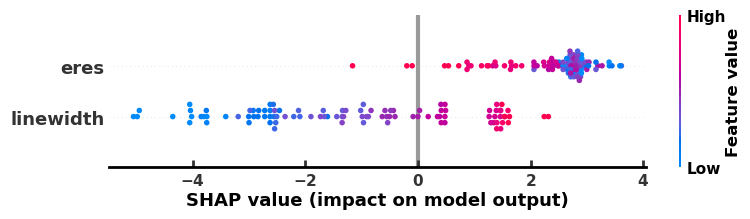

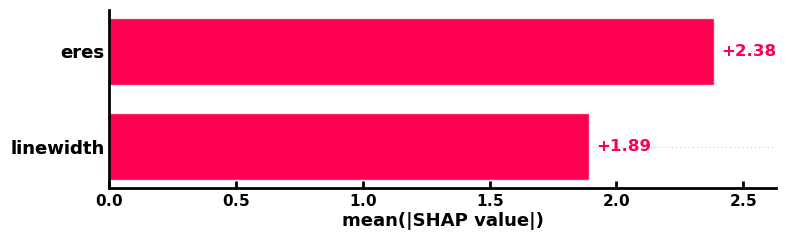

In [141]:
# Create the SHAP explainer (replace with your model)
explainer = shap.Explainer(wmodel, X_glass)

# Calculate SHAP values for the test data
shap_values = explainer(X_exp_ito)

# SHAP summary plot
shap.summary_plot(shap_values, X_exp_ito)
shap.plots.bar(shap_values)

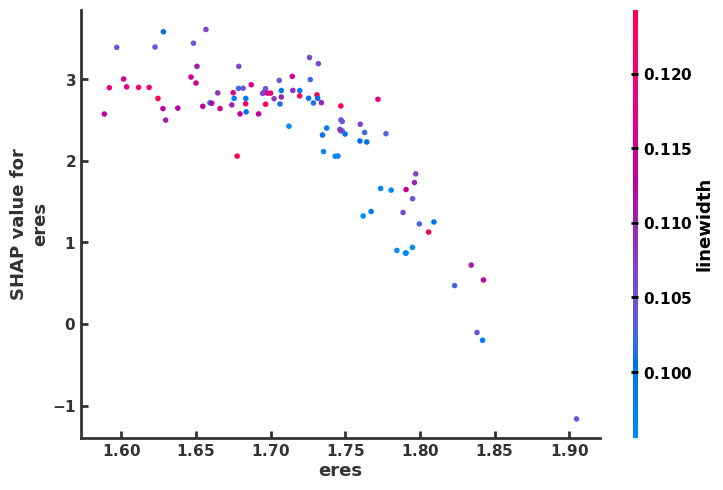

In [77]:
shap.dependence_plot('eres', shap_values.values, X_exp_ito)

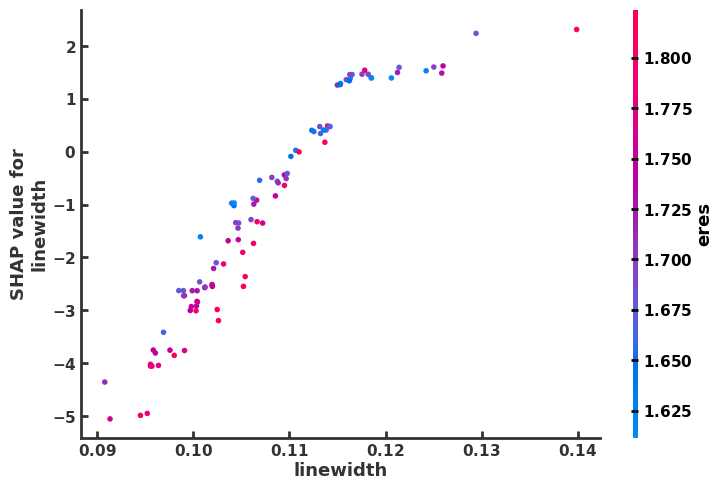

In [78]:
shap.dependence_plot('linewidth', shap_values.values, X_exp_ito)

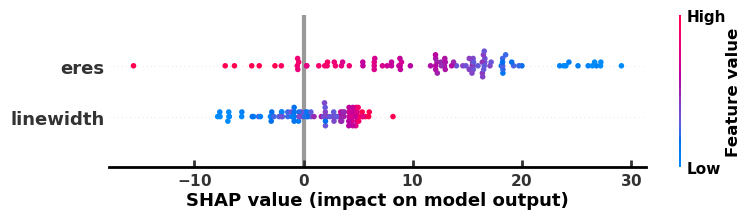

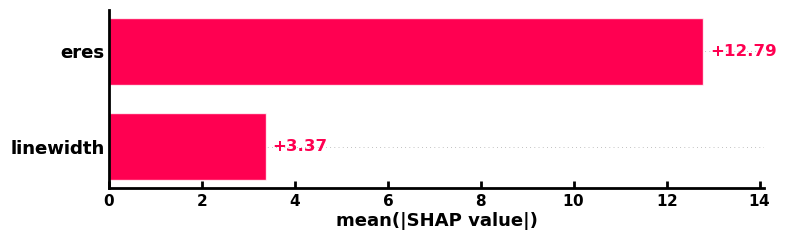

In [142]:
# Create the SHAP explainer (replace with your model)
explainer = shap.Explainer(lmodel, X_glass)

# Calculate SHAP values for the test data
shap_values = explainer(X_exp_ito)

# SHAP summary plot
shap.summary_plot(shap_values, X_exp_ito)
shap.plots.bar(shap_values)

## Corr. Glass to ITO

In [143]:
ITO_nsub = 1.96
ITO_Eres = numerical_method(ito_data, combined_data, target_nsub=ITO_nsub)
X_glass['eres'] = ITO_Eres

In [144]:
# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")


# create the specific number of data
exp_ito_data_sampled = exp_ito_data.sample(30, random_state=42)
exp_ito_data_sampled = exp_ito_data_sampled.reset_index(drop=True)

X_exp_ito = exp_ito_data_sampled.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'ratio', 'volume', 'surface_area'], axis=1)
yw_exp_ito = exp_ito_data_sampled['width']
yl_exp_ito = exp_ito_data_sampled['length']

# fitting
gsw.fit(X_glass, yw_glass)
yw_pred1 = gsw.predict(X_exp_ito)
maew1 = mean_absolute_error(yw_exp_ito, yw_pred1)

# fitting
gsl.fit(X_glass, yl_glass)
yl_pred1 = gsl.predict(X_exp_ito)
mael1 = mean_absolute_error(yl_exp_ito, yl_pred1)

In [145]:
wmodel = DecisionTreeRegressor(max_depth=gsw.best_params_['max_depth'],
                               min_samples_split=gsw.best_params_['min_samples_split'],
                               min_samples_leaf=gsw.best_params_['min_samples_leaf'])
lmodel = DecisionTreeRegressor(max_depth=gsl.best_params_['max_depth'],
                               min_samples_split=gsl.best_params_['min_samples_split'],
                               min_samples_leaf=gsl.best_params_['min_samples_leaf'])

# fitting
wmodel.fit(X_glass, yw_glass)
lmodel.fit(X_glass, yl_glass)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=5)

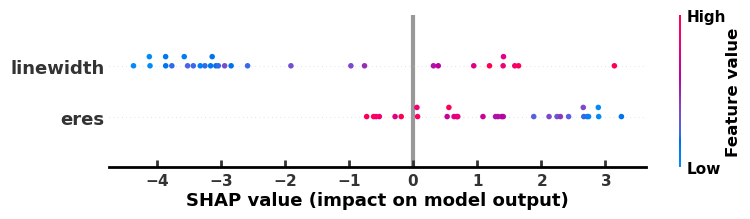

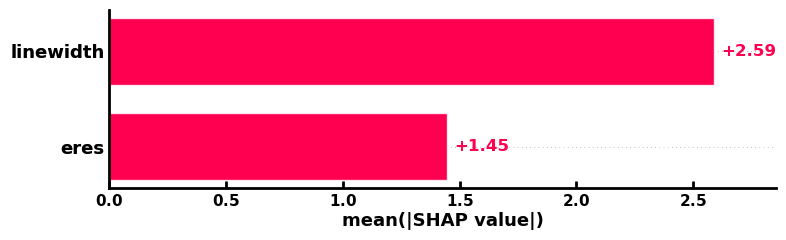

In [146]:
# Create the SHAP explainer (replace with your model)
explainer = shap.Explainer(wmodel, X_glass)

# Calculate SHAP values for the test data
shap_values = explainer(X_exp_ito)

# SHAP summary plot
shap.summary_plot(shap_values, X_exp_ito)
shap.plots.bar(shap_values)

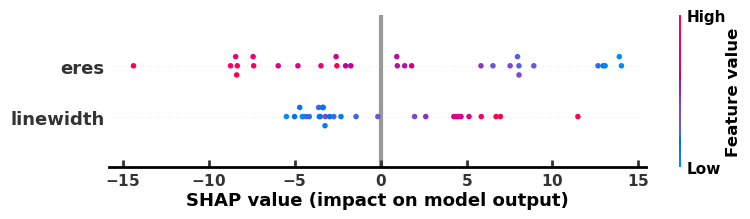

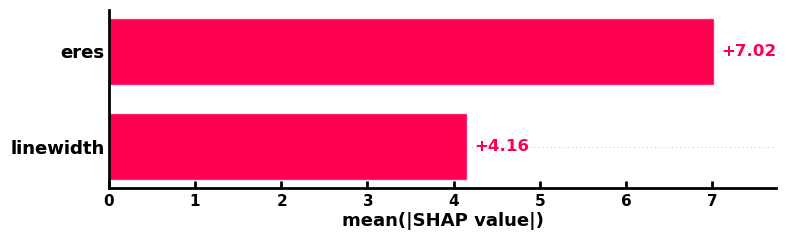

In [147]:
# Create the SHAP explainer (replace with your model)
explainer = shap.Explainer(lmodel, X_glass)

# Calculate SHAP values for the test data
shap_values = explainer(X_exp_ito)

# SHAP summary plot
shap.summary_plot(shap_values, X_exp_ito)
shap.plots.bar(shap_values)

## size dependence before and after the correction

In [148]:
## for linewidth correction too

def calc_dif(idx, ito_data, glass_data):
    Eres_glass = glass_data['eres'][idx]
    Linewidth_glass = glass_data['linewidth'][idx]
    AR_glass = glass_data['ratio'][idx]

    upper_min = ito_data[ito_data['ratio'] > AR_glass]['ratio'].min()
    lower_max = ito_data[ito_data['ratio'] < AR_glass]['ratio'].max()

    if abs(upper_min - AR_glass) > abs(lower_max - AR_glass):
        AR_ito_closest = lower_max
    else:
        AR_ito_closest = upper_min

    Eres_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['eres']
    Linewidth_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['linewidth']
    dEres_IG = Eres_ito - Eres_glass
    dLinewidth_IG = Linewidth_ito - Linewidth_glass
    return dEres_IG, dLinewidth_IG


def calculate_mean(lst):
    return sum(lst) / len(lst)


def numerical_method(ito_data, glass_data, target_nsub):
    ito_nsub = 1.96
    glass_nsub = 1.52
    dnsub_IG = ito_nsub - glass_nsub
    dEres_IG_list = []
    dLinewidth_IG_list = []
    for idx in range(glass_data.shape[0]):
        dEres_IG, dLinewidth_IG = calc_dif(idx, ito_data, glass_data)
        if (dEres_IG.shape == (1,)) and (dLinewidth_IG.shape == (1,)): 
            dEres_IG_list.append(dEres_IG.values)
            dLinewidth_IG_list.append(dLinewidth_IG.values)

    dEres_IG_mean = calculate_mean(dEres_IG_list)
    dLinewidth_IG_mean = calculate_mean(dLinewidth_IG_list)
    C = dEres_IG_mean / dnsub_IG
    D = dLinewidth_IG_mean / dnsub_IG
    target_Eres = C*(target_nsub - glass_nsub) + glass_data['eres']
    target_Linewidth = D*(target_nsub - glass_nsub) + glass_data['linewidth']
    return target_Eres, target_Linewidth

In [149]:
ITO_nsub = 1.96
ITO_Eres, ITO_Linewidth = numerical_method(ito_data, glass_data, target_nsub=ITO_nsub)

## Eres correction

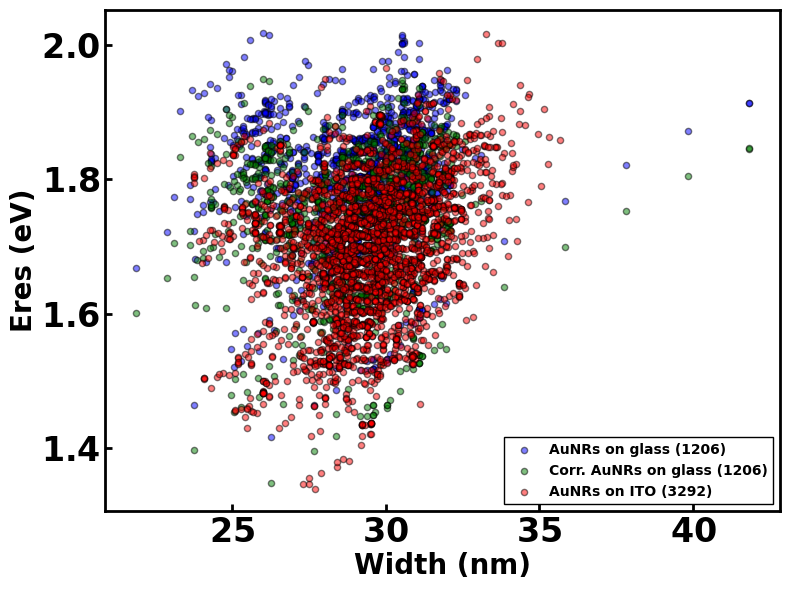

In [134]:
fig, ax = plt.subplots()

ax.scatter(glass_data['width'], glass_data['eres'], s=20, edgecolor='k', c='b', alpha=0.5, label=f'AuNRs on glass ({glass_data.shape[0]})')

ax.scatter(glass_data['width'], ITO_Eres, s=20, edgecolor='k', c='g', alpha=0.5, label=f'Corr. AuNRs on glass ({glass_data.shape[0]})')

ax.scatter(ito_data['width'], ito_data['eres'], s=20, edgecolor='k', c='r', alpha=0.5, label=f'AuNRs on ITO ({ito_data.shape[0]})')

ax.set_xlabel('Width (nm)')
ax.set_ylabel('Eres (eV)')
ax.legend(loc='lower right')

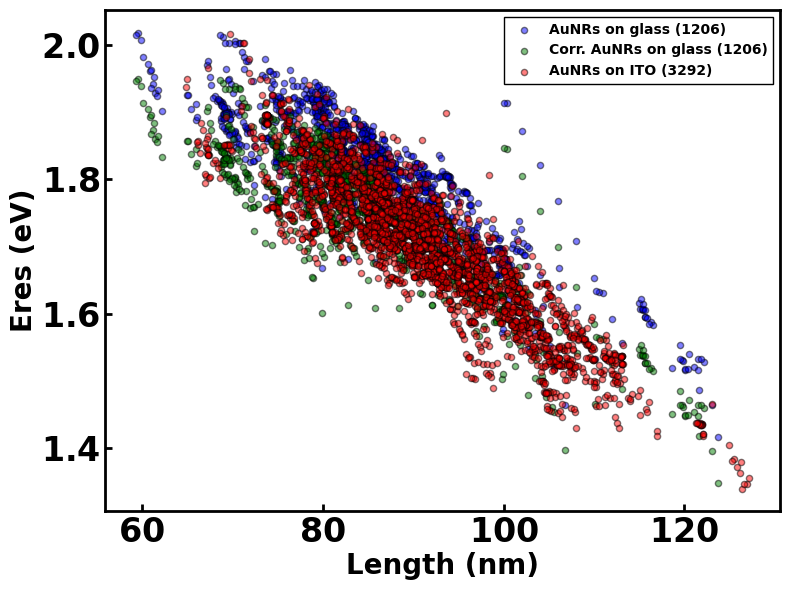

In [133]:
fig, ax = plt.subplots()

ax.scatter(glass_data['length'], glass_data['eres'], s=20, edgecolor='k', c='b', alpha=0.5, label=f'AuNRs on glass ({glass_data.shape[0]})')

ax.scatter(glass_data['length'], ITO_Eres, s=20, edgecolor='k', c='g', alpha=0.5, label=f'Corr. AuNRs on glass ({glass_data.shape[0]})')

ax.scatter(ito_data['length'], ito_data['eres'], s=20, edgecolor='k', c='r', alpha=0.5, label=f'AuNRs on ITO ({ito_data.shape[0]})')

ax.set_xlabel('Length (nm)')
ax.set_ylabel('Eres (eV)')
ax.legend()

## Linewidth correciton

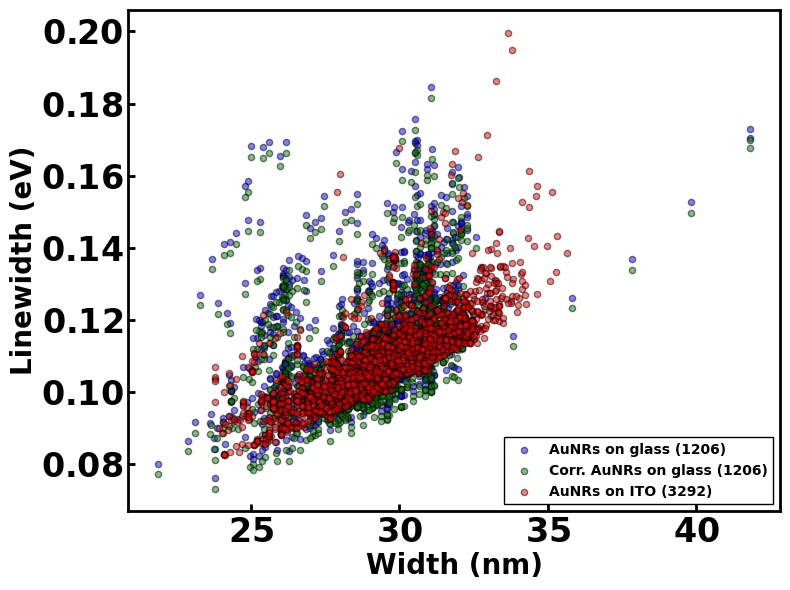

In [151]:
fig, ax = plt.subplots()

ax.scatter(glass_data['width'], glass_data['linewidth'], s=20, edgecolor='k', c='b', alpha=0.5, label=f'AuNRs on glass ({glass_data.shape[0]})')

ax.scatter(glass_data['width'], ITO_Linewidth, s=20, edgecolor='k', c='g', alpha=0.5, label=f'Corr. AuNRs on glass ({glass_data.shape[0]})')

ax.scatter(ito_data['width'], ito_data['linewidth'], s=20, edgecolor='k', c='r', alpha=0.5, label=f'AuNRs on ITO ({ito_data.shape[0]})')

ax.set_xlabel('Width (nm)')
ax.set_ylabel('Linewidth (eV)')
ax.legend(loc='lower right')

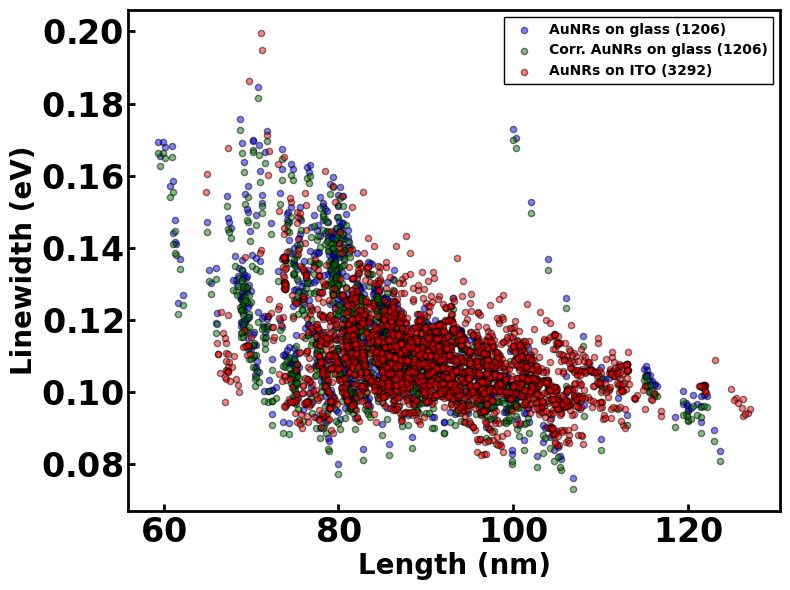

In [152]:
fig, ax = plt.subplots()

ax.scatter(glass_data['length'], glass_data['linewidth'], s=20, edgecolor='k', c='b', alpha=0.5, label=f'AuNRs on glass ({glass_data.shape[0]})')

ax.scatter(glass_data['length'], ITO_Linewidth, s=20, edgecolor='k', c='g', alpha=0.5, label=f'Corr. AuNRs on glass ({glass_data.shape[0]})')

ax.scatter(ito_data['length'], ito_data['linewidth'], s=20, edgecolor='k', c='r', alpha=0.5, label=f'AuNRs on ITO ({ito_data.shape[0]})')

ax.set_xlabel('Length (nm)')
ax.set_ylabel('Linewidth (eV)')
ax.legend()